# Generic HMC 

### Imports

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as _l2hmc
from l2hmc_eager import gauge_dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import GMM, gen_ring
from utils.jacobian import _map, jacobian
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

Using TensorFlow backend.


In [2]:
from u1_model_eager import *

In [3]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [4]:
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers

## Helper functions

In [5]:
def compute_ac_spectrum(samples_history, target_mean, target_covar):
    """Compute autocorrelation spectrum.
    Follows equation 15 from the L2HMC paper.
    Args:
        samples_history: Numpy array of shape [T, B, D], where T is the total
            number of time steps, B is the batch size, and D is the dimensionality
            of sample space.
        target_mean: 1D Numpy array of the mean of target(true) distribution.
        target_covar: 2D Numpy array representing a symmetric matrix for 
            variance.
    Returns:
        Autocorrelation spectrum, Numpy array of shape [T-1].
    """
    # Using numpy here since eager is a bit slow due to the loop
    time_steps = samples_history.shape[0]
    #trace = np.trace(target_covar)
    trace = 1.
    rhos = []
    for t in range(time_steps - 1):
        rho_t = 0.
        for tau in range(time_steps - t):
            v_tau = samples_history[tau, :] - target_mean
            v_tau_plus_t = samples_history[tau + t, :] - target_mean
            # Take dot product over observation dims and take mean over batch dims
            rho_t = v_tau.T.dot(v_tau_plus_t)
            #rho_t += np.mean(np.sum(v_tau * v_tau_plus_t, axis=1))
        rho_t /= trace * (time_steps - t)
        rhos.append(rho_t)
    return np.array(rhos)

## 2D $U(1)$ Lattice Gauge Theory

### Using L2HMC framework with hmc flag. `hmc=True`

In [6]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 8.,
    'num_samples': 5,
    'num_steps': 10, 
    'eps': 0.2,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_steps': 5000,
    #'record_loss_every': 50,
    #'data_steps': 1,
    'save_steps': 500,
    #'print_steps': 1,
    'logging_steps': 25,
    'clip_value': 100,
    'rand': False,
    'metric': 'l2',
    #'conv_net': False,
    #'hmc': True,
}
tf.reset_default_graph()

In [28]:
del model_hmc

In [11]:
tf.reset_default_graph()
config=tf.ConfigProto()

In [12]:
model_hmc = GaugeModel(params=params,
                       config=config,
                       sess=None,
                       conv_net=False,
                       hmc=True,
                       log_dir=None,
                       restore=False,
                       eps_trainable=False,
                       aux=False)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_35/
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_35/
info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_35/run_info/
figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_35/figures/
conv_net: False
hmc: True
aux: False
eps_trainable: False
time_size: 8
space_size: 8
link_type: U1
dim: 2
beta: 8.0
num_samples: 5
num_steps: 10
eps: 0.2
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.0001
learning_rate_decay_steps: 100
learning_rate_decay_rate: 0.96
train_steps: 5000
save_steps: 500
logging_steps: 25
clip_value: 100
rand: False
metric: l2
samples_history_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_35/samples_history
--------------------------------------------------------------------------------

Building graph... (started at: Fri Jan 11 00:58:57 2019)
  Creating loss...



Exception ignored in: <bound method TF_Output.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.TF_Output; proxy of <Swig Object of type 'TF_Output *' at 0x29b285fc0> >>
Traceback (most recent call last):
  File "/Users/saforem2/Library/Python/3.6/lib/python/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 1058, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
model_hmc.train(1000, kill_sess=False)

----------------------------------------------------------------------------
    STEP         LOSS    INV. TIME/STEP  ACCEPT %      EPS          LR     
----------------------------------------------------------------------------
    0/1000   -1.983e+04     0.035      0.8499       0.05       0.0001   
    1/1000   -1.443e+04   5.381e-05    0.8873       0.05       0.0001   
    2/1000      -8483     4.487e-05    0.9102       0.05       0.0001   
    3/1000      -8500     4.568e-05    0.9188       0.05       0.0001   
    4/1000      -6516     3.874e-05    0.9388       0.05       0.0001   
    5/1000      -6907     4.007e-05     0.953       0.05       0.0001   
    6/1000      -6741     4.242e-05    0.9426       0.05       0.0001   
    7/1000      -7225     4.023e-05    0.9915       0.05       0.0001   
    8/1000      -6088     4.408e-05     0.971       0.05       0.0001   
    9/1000      -5344     5.07e-05     0.9735       0.05       0.0001   
   10/1000      -4873     5.09e-05      

  109/1000      -2285     3.677e-05    0.9797       0.05       0.0001   
  110/1000      -2911     3.843e-05    0.9727       0.05       0.0001   
  111/1000      -2811     3.758e-05    0.9663       0.05       0.0001   
  112/1000      -2451     3.941e-05    0.9823       0.05       0.0001   
  113/1000      -2170     4.409e-05     0.96        0.05       0.0001   
  114/1000      -2290     3.26e-05     0.9596       0.05       0.0001   
  115/1000      -1876     3.703e-05    0.9495       0.05       0.0001   
  116/1000      -2196     4.261e-05    0.9884       0.05       0.0001   
  117/1000      -1954     3.882e-05    0.9573       0.05       0.0001   
  118/1000      -2376     3.679e-05    0.9748       0.05       0.0001   
  119/1000      -2086     3.596e-05    0.9233       0.05       0.0001   
  120/1000      -2972     3.505e-05    0.9982       0.05       0.0001   
  121/1000      -2413     3.57e-05     0.9365       0.05       0.0001   
  122/1000      -2451     4.218e-05    0.9093      

  221/1000      -2790     5.146e-05    0.9637       0.05       0.0001   
  222/1000      -2027     3.626e-05    0.9793       0.05       0.0001   
  223/1000      -2151     4.292e-05    0.9471       0.05       0.0001   
  224/1000      -2671     3.487e-05     0.982       0.05       0.0001   
  225/1000      -2883     4.533e-05    0.9818       0.05       0.0001   
  226/1000      -2623     4.419e-05    0.9902       0.05       0.0001   
  227/1000      -2801     3.788e-05     0.978       0.05       0.0001   
  228/1000      -3154     3.805e-05    0.9526       0.05       0.0001   
  229/1000      -2397     3.477e-05    0.9741       0.05       0.0001   
  230/1000      -2837     3.75e-05     0.9717       0.05       0.0001   
  231/1000      -3137     3.028e-05    0.9713       0.05       0.0001   
  232/1000      -2661     3.546e-05    0.9831       0.05       0.0001   
  233/1000      -2971     3.842e-05    0.9634       0.05       0.0001   
  234/1000      -2913     4.074e-05    0.9919      

  333/1000      -2740     4.587e-05    0.9878       0.05       0.0001   
  334/1000      -3083     3.922e-05    0.9251       0.05       0.0001   
  335/1000      -2593     3.701e-05    0.9723       0.05       0.0001   
  336/1000      -2862     4.864e-05    0.9796       0.05       0.0001   
  337/1000      -2712     4.207e-05    0.9819       0.05       0.0001   
  338/1000      -2525     4.371e-05    0.9984       0.05       0.0001   
  339/1000      -2917     3.92e-05     0.9719       0.05       0.0001   
  340/1000      -2547     3.392e-05    0.9325       0.05       0.0001   
  341/1000      -2210      4.3e-05      0.966       0.05       0.0001   
  342/1000      -3213     4.361e-05    0.9695       0.05       0.0001   
  343/1000      -2319     3.362e-05    0.9857       0.05       0.0001   
  344/1000      -2466     3.294e-05    0.9682       0.05       0.0001   
  345/1000      -2253     2.808e-05    0.9784       0.05       0.0001   
  346/1000      -1785     3.379e-05    0.9755      

  445/1000      -2183     3.897e-05    0.9785       0.05       0.0001   
  446/1000      -2237     3.424e-05     0.994       0.05       0.0001   
  447/1000      -2269     3.357e-05    0.9698       0.05       0.0001   
  448/1000      -1998     3.822e-05    0.9265       0.05       0.0001   
  449/1000      -2155     4.314e-05     0.98        0.05       0.0001   
  450/1000      -2353     3.292e-05     0.984       0.05       0.0001   
  451/1000      -2494     3.732e-05     0.981       0.05       0.0001   
  452/1000      -2154     3.627e-05    0.9584       0.05       0.0001   
  453/1000      -2618     3.705e-05    0.9675       0.05       0.0001   
  454/1000      -2833     3.359e-05    0.9598       0.05       0.0001   
  455/1000      -2662     3.651e-05    0.9823       0.05       0.0001   
  456/1000      -2520     3.075e-05    0.9648       0.05       0.0001   
  457/1000      -2270     3.409e-05    0.9916       0.05       0.0001   
  458/1000      -2062     3.298e-05    0.9914      

  553/1000      -2748     4.791e-05       1         0.05       0.0001   
  554/1000      -2834     3.978e-05    0.9544       0.05       0.0001   
  555/1000      -2789     4.16e-05     0.9754       0.05       0.0001   
  556/1000      -2078     3.572e-05    0.9861       0.05       0.0001   
  557/1000      -2191     5.442e-05    0.9408       0.05       0.0001   
  558/1000      -2554     4.412e-05    0.9775       0.05       0.0001   
  559/1000      -2099     5.299e-05    0.9583       0.05       0.0001   
  560/1000      -2325     4.614e-05    0.9384       0.05       0.0001   
  561/1000      -2823     4.421e-05    0.9847       0.05       0.0001   
  562/1000      -2858     4.68e-05        1         0.05       0.0001   
  563/1000      -2457     4.034e-05    0.9855       0.05       0.0001   
  564/1000      -2013     4.167e-05    0.9599       0.05       0.0001   
  565/1000      -2392     4.27e-05      0.972       0.05       0.0001   
  566/1000      -2753     4.852e-05    0.9916      

  665/1000      -2711     4.011e-05    0.9765       0.05       0.0001   
  666/1000      -3001     3.786e-05    0.9842       0.05       0.0001   
  667/1000      -2324     3.72e-05     0.9672       0.05       0.0001   
  668/1000      -2690     3.941e-05    0.9386       0.05       0.0001   
  669/1000      -2760     4.052e-05    0.9519       0.05       0.0001   
  670/1000      -3070     3.72e-05     0.9625       0.05       0.0001   
  671/1000      -2008     3.78e-05     0.9986       0.05       0.0001   
  672/1000      -2115     4.089e-05    0.9842       0.05       0.0001   
  673/1000      -2373     3.849e-05     0.982       0.05       0.0001   
  674/1000      -2973     3.63e-05     0.9386       0.05       0.0001   
  675/1000      -2789     4.132e-05     0.992       0.05       0.0001   
  676/1000      -2115     3.906e-05    0.9712       0.05       0.0001   
  677/1000      -2617      3.7e-05      0.951       0.05       0.0001   
  678/1000      -1952     3.852e-05    0.9992      

  777/1000      -2205     4.63e-05      0.956       0.05       0.0001   
  778/1000      -1936     3.735e-05    0.9824       0.05       0.0001   
  779/1000      -2592     5.222e-05    0.9663       0.05       0.0001   
  780/1000      -3303     5.475e-05    0.9791       0.05       0.0001   
  781/1000      -2286     3.784e-05    0.9458       0.05       0.0001   
  782/1000      -2803     3.941e-05       1         0.05       0.0001   
  783/1000      -2768     4.892e-05    0.9399       0.05       0.0001   
  784/1000      -3021     4.207e-05    0.9695       0.05       0.0001   
  785/1000      -2699     3.682e-05    0.9813       0.05       0.0001   
  786/1000      -2991     3.561e-05    0.9877       0.05       0.0001   
  787/1000      -2683     4.241e-05    0.9399       0.05       0.0001   
  788/1000      -2881     4.16e-05     0.9735       0.05       0.0001   
  789/1000      -2893     3.713e-05    0.9958       0.05       0.0001   
  790/1000      -2707     3.414e-05    0.9751      

  889/1000      -1761     3.521e-05    0.9478       0.05       0.0001   
  890/1000      -2734     3.85e-05     0.9676       0.05       0.0001   
  891/1000      -2397     4.448e-05    0.9704       0.05       0.0001   
  892/1000      -2482     4.66e-05     0.9652       0.05       0.0001   
  893/1000      -2661     5.261e-05       1         0.05       0.0001   
  894/1000      -2273     4.607e-05    0.9442       0.05       0.0001   
  895/1000      -2383     3.844e-05    0.9662       0.05       0.0001   
  896/1000      -2530     3.813e-05    0.9172       0.05       0.0001   
  897/1000      -2892     4.165e-05    0.9875       0.05       0.0001   
  898/1000      -2818     3.871e-05    0.9845       0.05       0.0001   
  899/1000      -2762     3.579e-05    0.9625       0.05       0.0001   
Time to complete logging: 0.2568

  900/1000      -2861     3.775e-05    0.9965       0.05       0.0001   
  901/1000      -2369     3.971e-05    0.9423       0.05       0.0001   
  902/1000      -

Time to complete saving: 90.31 

----------------------------------------------------------------------------
    STEP         LOSS    INV. TIME/STEP  ACCEPT %      EPS          LR     
----------------------------------------------------------------------------
Time to complete logging: 0.3554

Training complete!
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_17/model.ckpt



In [16]:
samples_history = model_hmc.run(250)

[autoreload of gauge_model failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._boots

Running (trained) L2HMC sampler for 10 steps...
step:   0     time / step / sample / link: 0.0002131
step:   1     time / step / sample / link: 5.395e-05
step:   2     time / step / sample / link: 3.98e-05
step:   3     time / step / sample / link: 3.669e-05
step:   4     time / step / sample / link: 3.325e-05
step:   5     time / step / sample / link: 3.708e-05
step:   6     time / step / sample / link: 4.236e-05
step:   7     time / step / sample / link: 7.439e-05
step:   8     time / step / sample / link: 7.047e-05
step:   9     time / step / sample / link: 3.91e-05
step:   10    time / step / sample / link: 3.915e-05
step:   11    time / step / sample / link: 3.47e-05
step:   12    time / step / sample / link: 3.982e-05
step:   13    time / step / sample / link: 4.523e-05
step:   14    time / step / sample / link: 3.18e-05
step:   15    time / step / sample / link: 4.321e-05
step:   16    time / step / sample / link: 3.283e-05
step:   17    time / step / sample / link: 3.205e-05
st

step:  155    time / step / sample / link: 5.024e-05
step:  156    time / step / sample / link: 5.176e-05
step:  157    time / step / sample / link: 5.069e-05
step:  158    time / step / sample / link: 7.644e-05
step:  159    time / step / sample / link: 5.664e-05
step:  160    time / step / sample / link: 5.8e-05
step:  161    time / step / sample / link: 5.691e-05
step:  162    time / step / sample / link: 5.649e-05
step:  163    time / step / sample / link: 5.734e-05
step:  164    time / step / sample / link: 5.47e-05
step:  165    time / step / sample / link: 6.97e-05
step:  166    time / step / sample / link: 6.367e-05
step:  167    time / step / sample / link: 9.795e-05
step:  168    time / step / sample / link: 9.665e-05
step:  169    time / step / sample / link: 9.04e-05
step:  170    time / step / sample / link: 5.449e-05
step:  171    time / step / sample / link: 5.976e-05
step:  172    time / step / sample / link: 5.227e-05
step:  173    time / step / sample / link: 6.261e-0

In [29]:
#model_hmc = GaugeModelEager(params=params,
                            #conv_net=False,
                            #hmc=True,
                            #log_dir=None,
                            #restore=False,
                            #defun=False,
                            #eps_trainable=False)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/
total initialization time: 0.038053274154663086

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/

_defun: False

conv_net: False

hmc: True

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 10

eps: 0.1

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 1

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

################################################################################




In [30]:
observables_hmc = model_hmc.calc_observables(model_hmc.dynamics.samples, 
                                             update=True)
total_actions, avg_plaquettes, top_charges = observables_hmc
helpers.print_run_data(model_hmc.data, header=True)
helpers.write_run_data(model_hmc.files['run_info_file'],  model_hmc.data)

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000       0         0         0        0.1        0         0         1     


In [31]:
_, _, _, samples_out = model_hmc.dynamics.apply_transition(model_hmc.samples)

In [32]:
model_hmc.train(500)

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    1/500      -40.48    0.7692    0.3034     0.1      6.989    -0.01881   0.9863  
    2/500      -55.29    0.867     0.3081     0.1      6.989    -0.01881   0.9863  
    3/500      -95.94    0.7718    0.3252     0.1      11.64    0.01805    0.9773  
    4/500      -126.4    0.8096    0.457      0.1      21.67   0.0002614   0.9577  
    5/500      -282.9    0.7955    0.9861     0.1      21.65    -0.03645   0.9577  
    6/500      -230.8    0.7623    0.6583     0.1       29.7    0.03306    0.942   
    7/500      -241.5    0.7552    0.8095     0.1      27.07    0.07956    0.9471  
    8/500      -212.7     1.19     0.6914     0.1       31.9    0.002052   0.9377  
    9/500      -355.9    0.933       1        0.1      28.28    0.04008    0.9448  
   10/500      -323.9    1.079       1        0.1       24.6    0.01987    

   92/500      -206.7    0.7304    0.7205     0.1      26.87    0.04317    0.9475  
   93/500      -166.6    0.7246    0.6637     0.1      32.41    0.02847    0.9367  
   94/500      -283.3    0.7466      1        0.1      28.12    0.03825    0.9451  
   95/500      -186.3    0.7276    0.5893     0.1      28.12    0.03825    0.9451  
   96/500      -186.5    0.7124    0.5749     0.1      31.22    0.01365    0.939   
   97/500      -228.4    0.7206    0.645      0.1      31.62   -0.007802   0.9382  
   98/500      -255.5    0.7401    0.8182     0.1      24.96    0.02443    0.9512  
   99/500      -249.2    0.7122    0.6608     0.1      24.96    0.02443    0.9512  
  100/500      -149.2    0.7329    0.6047     0.1      25.88    0.07187    0.9495  


Saved checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/ckpt-2


    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
-----------------------------------------------------------------------------

  182/500      -203.2    0.7227    0.7088     0.1      37.88    0.007701   0.926   
  183/500       -297     0.7156    0.9228     0.1      35.33    -0.04337   0.931   
  184/500      -216.8    0.7156    0.7429     0.1      35.87    -0.04021   0.9299  
  185/500       -231     0.7226    0.7206     0.1      34.76     -0.03     0.9321  
  186/500       -288     0.6684    0.7901     0.1      35.99    -0.04203   0.9297  
  187/500      -321.5     0.65     0.9755     0.1      38.61    0.001163   0.9246  
  188/500      -200.9    0.6771    0.6799     0.1      36.58    0.02266    0.9286  
  189/500      -275.9    0.667     0.8156     0.1      38.37    0.06629    0.9251  
  190/500      -189.9    0.6813    0.6423     0.1      43.39    -0.01201   0.9153  
  191/500      -287.8    0.6785    0.9427     0.1      43.84    0.01552    0.9144  
  192/500      -329.6    0.6798      1        0.1      38.95    0.01738    0.9239  
  193/500      -318.8    0.6675      1        0.1       32.5    -0.03319   0

  272/500      -250.2    0.7145    0.8771     0.1      34.72    0.02043    0.9322  
  273/500      -302.2    0.6827    0.9507     0.1      30.29    0.02432    0.9408  
  274/500      -276.6    0.6748    0.874      0.1      30.17   -0.005046   0.9411  
  275/500      -307.6    0.685       1        0.1      30.86    -0.04238   0.9397  
  276/500      -171.3    0.6754    0.7546     0.1      29.19    -0.01301   0.943   
  277/500      -268.8    0.6768    0.9007     0.1      28.76   -0.005173   0.9438  
  278/500      -270.7    0.6772    0.8057     0.1      31.97    -0.03944   0.9376  
  279/500      -229.8    0.6744     0.8       0.1      24.45    -0.04983   0.9522  
  280/500      -158.3    0.6973    0.5442     0.1      28.19   -0.001211   0.9449  
  281/500      -277.7    0.6748      1        0.1      27.06    -0.01383   0.9471  
  282/500      -327.4    0.6781      1        0.1      26.14    0.007509   0.949   
  283/500      -272.8    0.6797    0.8268     0.1      24.94    -0.01358   0

  362/500      -184.7    0.6927    0.5991     0.1       40.5    0.02036    0.9209  
  363/500      -257.8    0.6809    0.7161     0.1      41.06    0.06429    0.9198  
  364/500      -272.6    0.6862    0.8153     0.1      42.19    0.04601    0.9176  
  365/500      -392.5    0.6836      1        0.1      38.35    0.02736    0.9251  
  366/500      -193.8    0.6847    0.722      0.1      37.89    0.04884    0.926   
  367/500      -291.5    0.669       1        0.1      35.41    0.03017    0.9308  
  368/500       -275     0.683     0.8262     0.1      33.56    0.01836    0.9345  
  369/500      -355.3    0.6791    0.9419     0.1      33.97    -0.01755   0.9336  
  370/500      -282.9    0.6828    0.8144     0.1      34.69   -0.005942   0.9323  
  371/500      -410.6    0.692       1        0.1      28.43    -0.03833   0.9445  
  372/500      -216.8    0.6872    0.7956     0.1       31.6   -0.005274   0.9383  
  373/500      -241.9    0.6812    0.6875     0.1       38.3    -0.04251   0

  452/500      -294.1    0.6619      1        0.1      32.64    0.06394    0.9363  
  453/500      -340.5    0.6844      1        0.1      32.85   -0.003956   0.9358  
  454/500      -330.7    0.6884      1        0.1      25.52     0.0464    0.9502  
  455/500      -122.6    0.6763    0.4651     0.1      25.52     0.0464    0.9502  
  456/500      -143.9    0.6908    0.4619     0.1      25.52     0.0464    0.9502  
  457/500      -225.1    0.6782    0.7208     0.1      27.85    -0.02038   0.9456  
  458/500      -152.5    0.6865    0.5416     0.1      31.44    0.02219    0.9386  
  459/500      -266.2    0.665     0.9122     0.1      28.34    0.01261    0.9447  
  460/500      -172.9    0.6841    0.6746     0.1      33.55    0.01619    0.9345  
  461/500      -276.4    0.6835    0.7827     0.1      35.75    0.03909    0.9302  
  462/500       -304     0.6674      1        0.1      28.01    0.07006    0.9453  
  463/500       -212     0.702     0.7846     0.1      27.61     0.0504    0

Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_plaquettes_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_topological_charge_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_total_action_vs_step.pdf...
done.


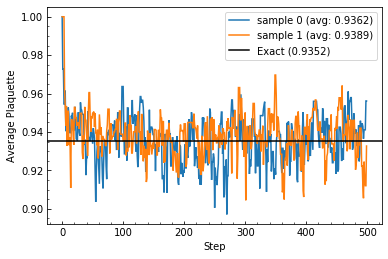

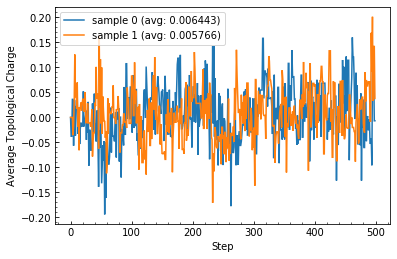

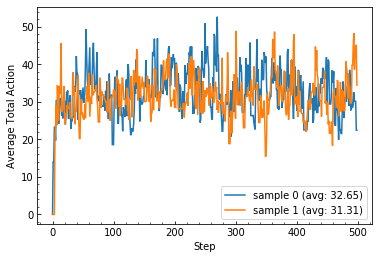

In [34]:
steps_arr = [0]
steps_arr.extend(model_hmc.steps_arr)

_ = helpers.plot_run_data(model_hmc.data, model_hmc.params, steps_arr, 
                          model_hmc.figs_dir, skip_steps=1)

In [36]:
samples_hmc = tf.random_normal(shape=model_hmc.samples.shape)
samples_history_hmc = []
actions_history_hmc = []
avg_plaquettes_history_hmc = []
top_charges_history_hmc = []

In [37]:
for i in range(500):
    #samples_history_hmc.append(samples_hmc.numpy())
    t0 = time.time()
    #_, _, _, samples_hmc = apply_transition_hmc(samples_hmc)
    _, _, _, samples_hmc = model_hmc.dynamics.apply_transition(samples_hmc)
    observables_hmc = np.array(
        model_hmc.lattice.calc_plaq_observables(samples_hmc)
    ).T
    actions_history_hmc.append(observables_hmc[0])
    avg_plaquettes_history_hmc.append(observables_hmc[1])
    top_charges_history_hmc.append(observables_hmc[2])
    step_time = (time.time() - t0) / (model_hmc.num_steps * model_hmc.batch_size)
    print(f'step: {i}  time/step: {step_time:^6.4g} '
          f'top_charge: {np.mean(observables_hmc[2]):^6.4g} '
          f'avg_plaq: {np.mean(observables_hmc[1]):^6.4g}')

step: 0  time/step: 0.3685 top_charge: 0.1002 avg_plaq: 0.4384
step: 1  time/step: 0.4859 top_charge: -0.03979 avg_plaq: 0.6422
step: 2  time/step: 0.5687 top_charge: 0.1123 avg_plaq: 0.7524
step: 3  time/step: 0.5015 top_charge: 0.03645 avg_plaq: 0.8183
step: 4  time/step: 0.4995 top_charge: -0.03705 avg_plaq: 0.8544
step: 5  time/step: 0.4824 top_charge: -0.01861 avg_plaq: 0.8785
step: 6  time/step: 0.4547 top_charge: -0.01154 avg_plaq: 0.8852
step: 7  time/step: 0.3464 top_charge: -0.06579 avg_plaq: 0.8683
step: 8  time/step: 0.2614 top_charge: -0.04183 avg_plaq: 0.8796
step: 9  time/step: 0.266  top_charge: -0.05311 avg_plaq: 0.8974
step: 10  time/step: 0.2645 top_charge: -0.004249 avg_plaq: 0.8929
step: 11  time/step: 0.2571 top_charge: -0.0461 avg_plaq: 0.8961
step: 12  time/step: 0.2623 top_charge: 0.03281 avg_plaq: 0.901 
step: 13  time/step: 0.2537 top_charge: -0.06774 avg_plaq: 0.8958
step: 14  time/step: 0.2617 top_charge: 0.028  avg_plaq: 0.8857
step: 15  time/step: 0.2764 

step: 125  time/step: 0.3532 top_charge: 0.02008 avg_plaq: 0.9394
step: 126  time/step: 0.248  top_charge: -0.03363 avg_plaq: 0.9285
step: 127  time/step: 0.2653 top_charge: 0.005896 avg_plaq: 0.9321
step: 128  time/step: 0.2494 top_charge: -0.04765 avg_plaq: 0.9324
step: 129  time/step: 0.2647 top_charge: -0.03726 avg_plaq: 0.9378
step: 130  time/step: 0.2528 top_charge: 0.006098 avg_plaq: 0.9364
step: 131  time/step: 0.244  top_charge: -0.0247 avg_plaq: 0.9233
step: 132  time/step: 0.2486 top_charge: 0.03184 avg_plaq: 0.9284
step: 133  time/step: 0.2564 top_charge: 0.02464 avg_plaq: 0.9388
step: 134  time/step: 0.2482 top_charge: 0.02464 avg_plaq: 0.9388
step: 135  time/step: 0.2535 top_charge: 0.007148 avg_plaq: 0.9375
step: 136  time/step: 0.3485 top_charge: 0.007148 avg_plaq: 0.9375
step: 137  time/step: 0.327  top_charge: 0.07536 avg_plaq: 0.9286
step: 138  time/step: 0.2802 top_charge: 0.06886 avg_plaq: 0.9294
step: 139  time/step: 0.306  top_charge: 0.03697 avg_plaq: 0.9375
ste

step: 249  time/step: 0.3653 top_charge: 0.0412 avg_plaq: 0.9366
step: 250  time/step: 0.2752 top_charge: 0.05367 avg_plaq: 0.9432
step: 251  time/step: 0.2883 top_charge: 0.05621 avg_plaq: 0.9343
step: 252  time/step: 0.3961 top_charge: 0.0447 avg_plaq: 0.924 
step: 253  time/step: 0.2639 top_charge: 0.02222 avg_plaq: 0.9239
step: 254  time/step: 0.2982 top_charge: 0.01166 avg_plaq: 0.9318
step: 255  time/step: 0.2644 top_charge: 0.06964 avg_plaq: 0.9334
step: 256  time/step: 0.2604 top_charge: -0.03378 avg_plaq: 0.9312
step: 257  time/step: 0.2608 top_charge: -0.01406 avg_plaq: 0.9362
step: 258  time/step: 0.2509 top_charge: -0.04193 avg_plaq: 0.9341
step: 259  time/step: 0.2626 top_charge: -0.03159 avg_plaq: 0.9356
step: 260  time/step: 0.2533 top_charge: -0.03515 avg_plaq: 0.9303
step: 261  time/step: 0.2557 top_charge: 0.06351 avg_plaq: 0.9357
step: 262  time/step:  0.29  top_charge: -0.01158 avg_plaq: 0.9488
step: 263  time/step: 0.2624 top_charge: -0.01158 avg_plaq: 0.9488
step:

step: 372  time/step: 0.2425 top_charge: -0.04755 avg_plaq: 0.9335
step: 373  time/step: 0.235  top_charge: -0.04755 avg_plaq: 0.9335
step: 374  time/step: 0.2521 top_charge: -0.04755 avg_plaq: 0.9335
step: 375  time/step: 0.2463 top_charge: -0.05362 avg_plaq: 0.9233
step: 376  time/step: 0.2503 top_charge: -0.03463 avg_plaq: 0.9361
step: 377  time/step: 0.2336 top_charge: -0.06211 avg_plaq: 0.936 
step: 378  time/step: 0.2393 top_charge: -0.042 avg_plaq: 0.9246
step: 379  time/step: 0.2393 top_charge: -0.01977 avg_plaq: 0.9319
step: 380  time/step: 0.2453 top_charge: -0.02288 avg_plaq: 0.9419
step: 381  time/step: 0.2424 top_charge: -0.01033 avg_plaq: 0.9461
step: 382  time/step: 0.2445 top_charge: -0.02988 avg_plaq: 0.9405
step: 383  time/step: 0.2397 top_charge: -0.0515 avg_plaq: 0.9363
step: 384  time/step: 0.2461 top_charge: 0.01484 avg_plaq: 0.915 
step: 385  time/step: 0.2395 top_charge: -0.028 avg_plaq: 0.919 
step: 386  time/step: 0.2437 top_charge: -0.02478 avg_plaq: 0.9267
s

step: 495  time/step: 0.4844 top_charge: 0.03485 avg_plaq: 0.9133
step: 496  time/step: 0.2957 top_charge: 0.03973 avg_plaq: 0.9158
step: 497  time/step: 0.2765 top_charge: 0.09574 avg_plaq: 0.9105
step: 498  time/step: 0.312  top_charge: 0.08096 avg_plaq: 0.9211
step: 499  time/step: 0.2459 top_charge: 0.07622 avg_plaq: 0.928 


In [39]:
actions_history_hmc = np.array(actions_history_hmc)
avg_plaquettes_history_hmc = np.array(avg_plaquettes_history_hmc)
top_charges_history_hmc = np.array(top_charges_history_hmc)

In [40]:
top_charges_autocorr0_hmc = autocorr(top_charges_history_hmc[:, 0])
top_charges_autocorr1_hmc = autocorr(top_charges_history_hmc[:, 1])

top_charges_autocorr_hmc = (top_charges_autocorr0_hmc 
                            + top_charges_autocorr1_hmc) / 2

<IPython.core.display.Javascript object>


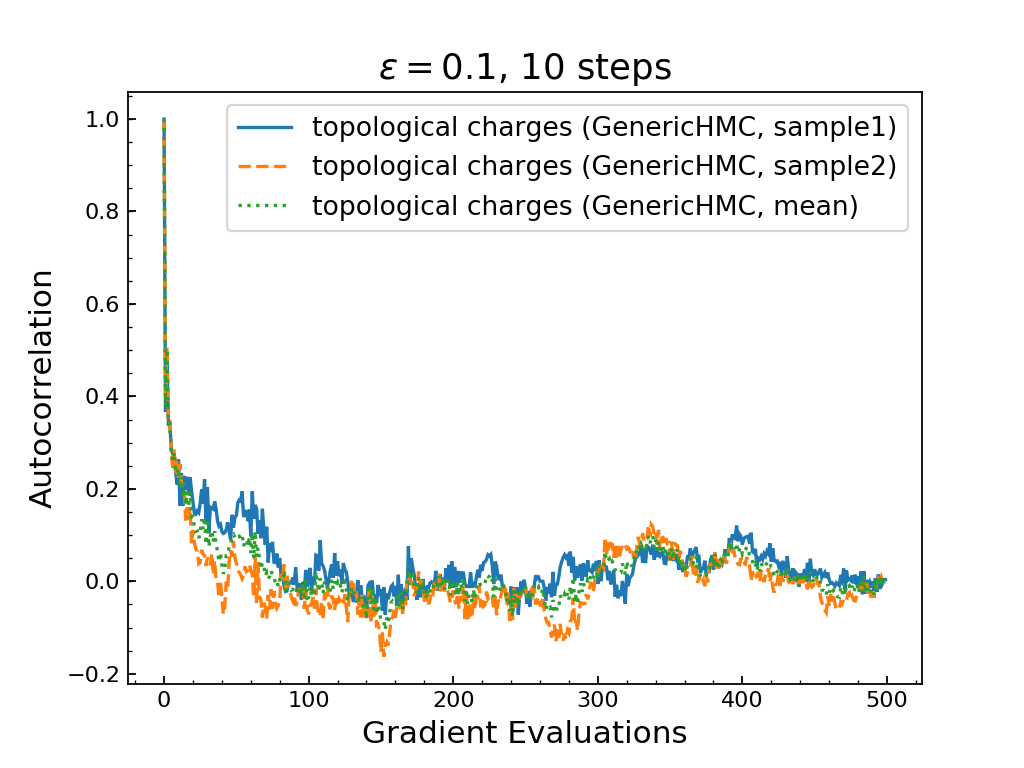

Text(0.5,1,'$\\epsilon = 0.1$, 10 steps')

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [53]:
steps_hmc = np.arange(len(top_charges_autocorr_hmc))

fig, ax = plt.subplots()
#ax.plot(steps_hmc, top_charges_autocorr_hmc, 
#        marker='', ls='-', label='topological_charge (HMC)')
#ax.plot(steps_hmc, avg_plaquettes_autocorr_hmc,
#        marker='', ls='--', label='avg plaquettes (L2HMC, hmcNet)')
ax.plot(steps_hmc, top_charges_autocorr0_hmc,
        marker='', ls='-', label='topological charges (GenericHMC, sample1)')
ax.plot(steps_hmc, top_charges_autocorr1_hmc,
        marker='', ls='--', label='topological charges (GenericHMC, sample2)')
ax.plot(steps_hmc, top_charges_autocorr_hmc,
        marker='', ls=':', label='topological charges (GenericHMC, mean)')
#ax.plot(steps1, top_charges_autocorr, marker='', ls='-', label='topological_charge (L2HMC)')
ax.set_title(r"$\epsilon = 0.1$, 10 steps", fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
fig.savefig(os.path.join(model_hmc.figs_dir, 
                         'top_charge_autocorrelation_fn_hmc.pdf'), 
            dpi=400, bbox_inches='tight')
#ax.set_xlim((ax.get_xlim()[0], 1000))
#ax.set_xlim((-5, 1000))
plt.show()

### Using HMC.hmc method (separate from L2HMC)

In [5]:
dirs = helpers.create_log_dir('gauge_logs_graph/hmc.HMC')
log_dir, info_dir, figs_dir = dirs

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/hmc.HMC/run_2/


In [24]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 8.,
    'num_samples': 5,
    'num_steps': 5, 
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_steps': 1000,
    'record_loss_every': 50,
    'data_steps': 1,
    'save_steps': 50,
    'print_steps': 1,
    'logging_steps': 5,
    'clip_value': 100,
    'rand': False,
    'metric': 'l2',
    #'conv_net': False,
    #'hmc': True,
}

In [25]:
lattice = GaugeLattice(time_size=params['time_size'],
                       space_size=params['space_size'],
                       dim=params['dim'],
                       beta=params['beta'],
                       link_type=params['link_type'],
                       num_samples=params['num_samples'],
                       rand=params['rand'])
samples = np.array([sample.flatten() for sample in lattice.samples])
lattice_energy_fn = lattice.get_energy_function(samples)

In [26]:
#position_init = lattice.links.flatten()
lattice_hmc = HMC(position_init=samples,
                  step_size=params['eps'],
                  n_leapfrog_steps=params['num_steps'],
                  potential_fn=lattice_energy_fn,
                  grad_potential_fn=None,
                  beta=lattice.beta)

In [27]:
#links = lattice.links.flatten()
momentum = np.random.randn(*samples.shape)
#links_arr = [links]
probs_arr = []
#total_actions = []
#average_plaquettes = []
#topological_charges = []
samples_arr = []
#links = links
print("Exact value of the average plaquette "
      f"(at {params['beta']}): {u1_plaq_exact(params['beta'])}")

Exact value of the average plaquette (at 8.0): 0.9352354935294382


#### Run HMC algorithm

In [28]:
eval_steps_arr = [100, 500, 1000, 5000]
for eval_steps in eval_steps_arr:
    for i in range(eval_steps):
        t1 = time.time()
        if isinstance(samples, tf.Tensor):
            samples_arr.append(samples.numpy())
        else: 
            samples_arr.append(samples)
        samples, vel, probs = lattice_hmc.apply_transition(samples)
        probs_arr.append(probs)
        #observables = np.array(lattice._calc_plaq_observables(links1))
        #_total_actions = observables[0]
        #_avg_plaquettes = observables[1]
        #_top_charges = observables[2]

        #total_actions.append(_total_actions)
        #average_plaquettes.append(_avg_plaquettes)
        #topological_charges.append(_top_charges)
        tt = ((time.time() - t1) 
              / (params['num_steps'] 
                 * lattice.num_samples 
                 * lattice.num_links))
        print(f"\nstep: {i:<5g} accept rate: {np.mean(probs):^8.5g}  "
              f" time/step/sample/link: {tt:^6.4g} ")
              #f' avg_S: {np.mean(_total_actions):^8.5g} '
              #f' avg_topQ: {np.mean(_top_charges):^8.5g} '
              #f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}')


step: 0     accept rate: 0.47253    time/step/sample/link: 0.001371 

step: 1     accept rate: 0.61155    time/step/sample/link: 0.001113 

step: 2     accept rate: 0.74722    time/step/sample/link: 0.0009969 

step: 3     accept rate: 0.66538    time/step/sample/link: 0.001258 

step: 4     accept rate: 0.72005    time/step/sample/link: 0.001134 

step: 5     accept rate: 0.79804    time/step/sample/link: 0.001124 

step: 6     accept rate: 0.93328    time/step/sample/link: 0.001254 

step: 7     accept rate: 0.87675    time/step/sample/link: 0.001258 

step: 8     accept rate: 0.82426    time/step/sample/link: 0.00126 

step: 9     accept rate: 0.87098    time/step/sample/link: 0.001128 

step: 10    accept rate: 0.98148    time/step/sample/link: 0.001118 

step: 11    accept rate: 0.78966    time/step/sample/link: 0.001302 

step: 12    accept rate:  0.7593    time/step/sample/link: 0.001222 

step: 13    accept rate: 0.86398    time/step/sample/link: 0.001028 

step: 14    accept 


step: 18    accept rate: 0.84974    time/step/sample/link: 0.001123 

step: 19    accept rate: 0.83324    time/step/sample/link: 0.001047 

step: 20    accept rate: 0.87762    time/step/sample/link: 0.001045 

step: 21    accept rate: 0.98318    time/step/sample/link: 0.001351 

step: 22    accept rate: 0.80445    time/step/sample/link: 0.001481 

step: 23    accept rate:    1       time/step/sample/link: 0.001386 

step: 24    accept rate: 0.85751    time/step/sample/link: 0.001359 

step: 25    accept rate: 0.97434    time/step/sample/link: 0.001314 

step: 26    accept rate: 0.86515    time/step/sample/link: 0.0015 

step: 27    accept rate: 0.77052    time/step/sample/link: 0.001165 

step: 28    accept rate: 0.84612    time/step/sample/link: 0.001321 

step: 29    accept rate: 0.91452    time/step/sample/link: 0.001175 

step: 30    accept rate: 0.63215    time/step/sample/link: 0.001229 

step: 31    accept rate: 0.94388    time/step/sample/link: 0.001741 

step: 32    accept ra

KeyboardInterrupt: 

In [29]:
samples_arr = np.array(samples_arr)
samples_arr.shape

(210, 5, 128)

In [31]:
samples_arr[0][0][:10]
samples_arr[1][0][:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([-0.17254917, -0.01462017, -0.02799418,  0.18913089,  0.13067448,
       -0.21386299, -0.03627994,  0.11209875, -0.78791598, -0.1948119 ])

In [32]:
import pickle
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
parameters_file = os.path.join(info_dir, 'parameters.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(np.array(samples_arr), f)
with open(parameters_file, 'wb') as f:
    pickle.dump(params, f)

In [36]:
observables = np.array([
    lattice.calc_plaq_observables(samples=samples_arr[i]) for i in range(100)
])
#total_actions, avg_plaquettes, top_charges = observables

In [37]:
observables.shape

(100, 3, 5)

In [38]:
actions = observables[:, 0, :]
plaquettes = observables[:, 1, :]
charges = observables[:, 2, :]

In [39]:
actions.shape

(100, 5)

In [40]:
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

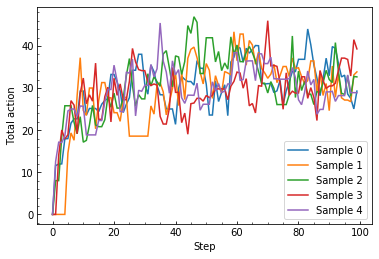

In [42]:
fig, ax = plt.subplots()
for idx in range(actions.shape[1]):
    _ = ax.plot(actions[:, idx], label=f'Sample {idx}', color=COLORS[idx])
    
_ = ax.legend(loc='best')
_ = ax.set_xlabel('Step')
_ = ax.set_ylabel('Total action')

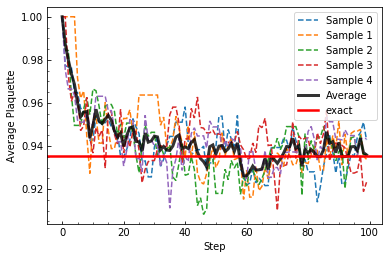

In [51]:
fig, ax = plt.subplots()
for idx in range(plaquettes.shape[1]):
    _ = ax.plot(plaquettes[:, idx], label=f'Sample {idx}', color=COLORS[idx], ls='--')

_ = ax.plot(plaquettes.mean(axis=1), label="Average", color='k', alpha=0.8,
            lw=3.)
    
_ = ax.axhline(y=u1_plaq_exact(lattice.beta), 
               color='r', ls='-', lw=2.5, label='exact')
    
_ = ax.legend(loc='best')
_ = ax.set_xlabel('Step')
_ = ax.set_ylabel('Average Plaquette')

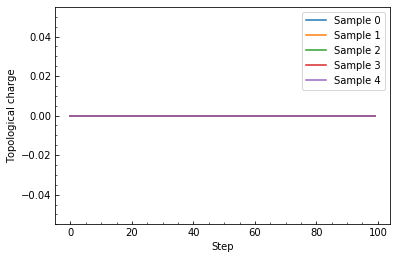

In [52]:
fig, ax = plt.subplots()
for idx in range(charges.shape[1]):
    _ = ax.plot(charges[:, idx], label=f'Sample {idx}', color=COLORS[idx])
    
_ = ax.legend(loc='best')
_ = ax.set_xlabel('Step')
_ = ax.set_ylabel('Topological charge')

#### Compute autocorrelations

In [20]:
total_actions = np.array(total_actions)
avg_plaquettes = np.array(avg_plaquettes)
top_charges = np.array(top_charges)
samples_arr = np.array(samples_arr)
print(total_actions.shape, avg_plaquettes.shape, top_charges.shape)

(500,) (500,) (500,)


In [24]:
top_charges_autocorr = autocorr(top_charges)

links_autocorr_arr = [
    autocorr(sample) for sample in samples_arr.T
]

links_autocorr_arr = np.array(links_autocorr_arr)

#### Save samples, params

In [25]:
samples_history_file = os.path.join(info_dir, 'sample_history.pkl')
with open(samples_history_file, 'wb') as f:
    _ = pickle.dump(samples_arr, f)
    
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'wb') as f:
    _ = pickle.dump(samples_arr, f)
    
params_txt_file = os.path.join(info_dir, 'parameters.txt')
with open(params_txt_file, 'w') as f:
    for key, val in params.items():
        _ = f.write(f'{key}: {val}\n')

#### Plot autocorrelation of top. charge and individual links

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


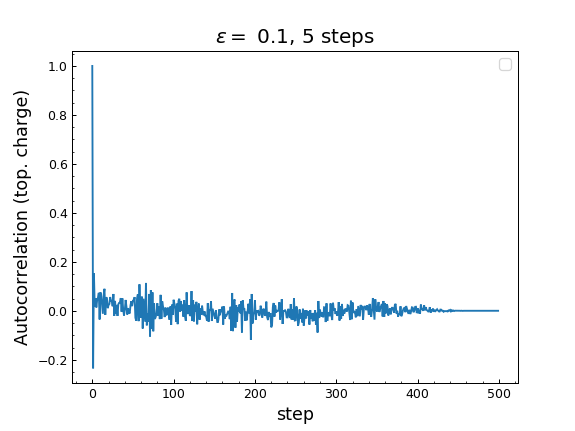

Text(0.5,1,'$\\epsilon =$ 0.1, 5 steps')

Text(0,0.5,'Autocorrelation (top. charge)')

Text(0.5,0,'step')

No handles with labels found to put in legend.


In [28]:
steps_hmc = np.arange(len(top_charges_autocorr))

fig, ax = plt.subplots()
ax.plot(steps_hmc, top_charges_autocorr,
        marker='', ls='-')#, label='')
title_str = (rf"$\epsilon =$ {params['eps']}, {params['num_steps']} steps")
ax.set_title(title_str, fontsize=16)
ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
ax.set_xlabel('step', fontsize=14)
ax.legend(loc='best', fontsize=12)
out_file = os.path.join(
    figs_dir,  'top_charge_autocorrelation_fn_hmc.pdf'
)
plt.savefig(out_file, dpi=400, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


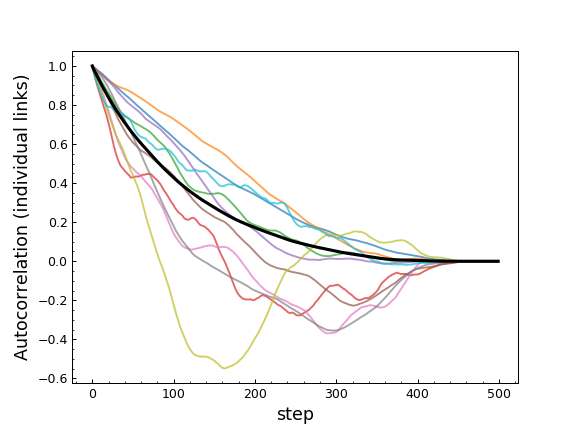

In [31]:
steps = np.arange(len(links_autocorr_arr.T))
fig, ax = plt.subplots()
for i in range(10):
    _ = ax.plot(steps, links_autocorr_arr[i, :], label=f'link {i}', ls='-',
                alpha=0.7)
    #_ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
    #            label=f'{key}')
_ = ax.plot(steps, links_autocorr_arr.mean(axis=0), label='average',
            color='k', lw=2.5)
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (individual links)', fontsize=14)
#_ = ax.legend(loc='best')
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


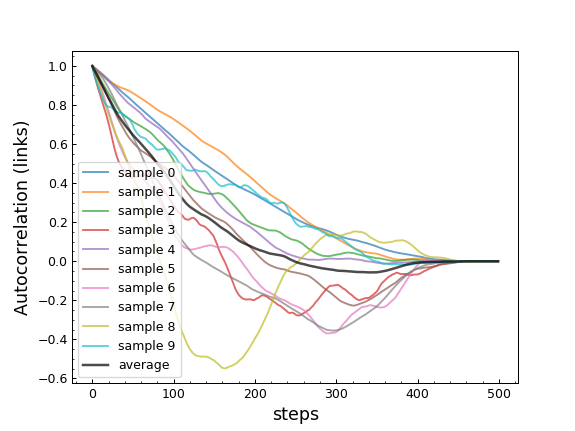

In [32]:
steps = np.arange(len(links_autocorr_arr.T))
fig, ax = plot_multiple_lines(steps, links_autocorr_arr[:10, :], 
                              x_label='steps', 
                              y_label='Autocorrelation (links)')

# OLD

In [70]:
target_mean = np.mean(samples_arr, axis=0)

In [71]:
samples_autocorr = compute_ac_spectrum(samples_arr, target_mean=target_mean,
                                       target_covar=None)

<IPython.core.display.Javascript object>


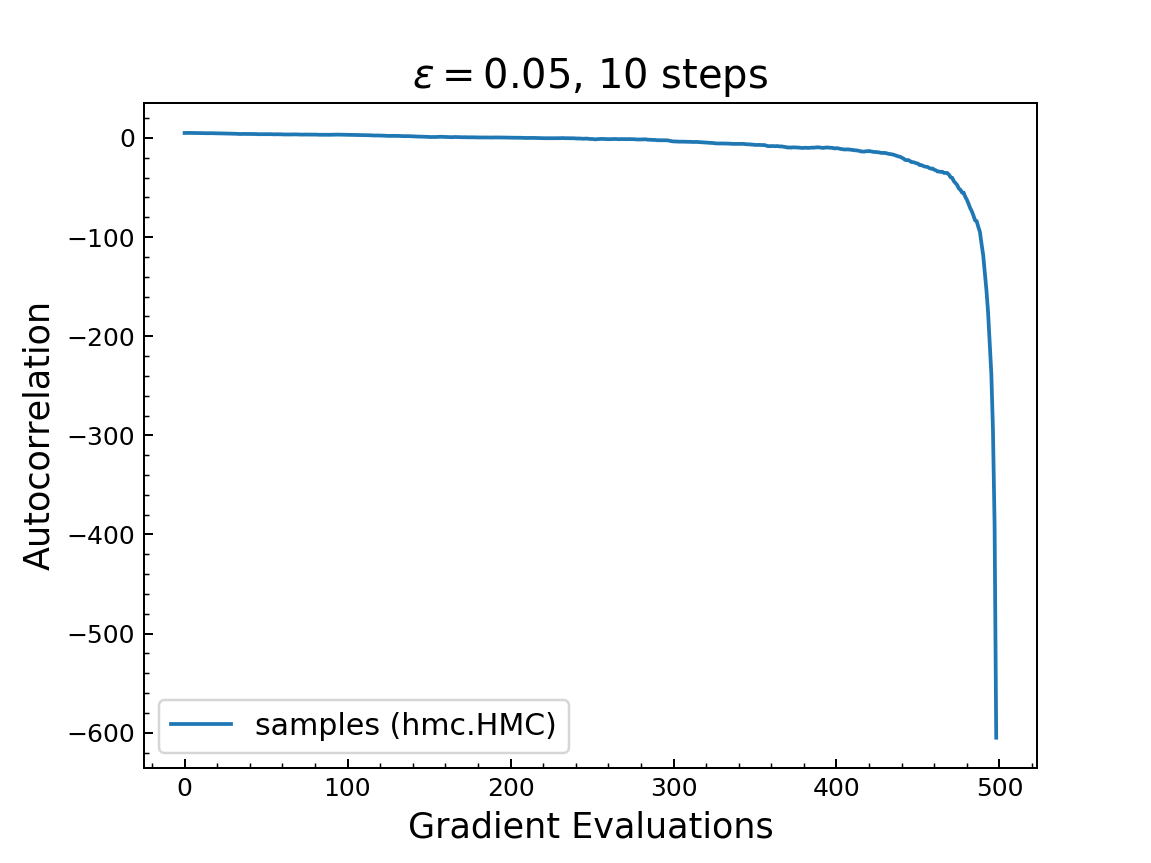

Text(0.5,1,'$\\epsilon = 0.05$, 10 steps')

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [72]:
steps_hmc = np.arange(len(samples_autocorr))

fig, ax = plt.subplots()
ax.plot(steps_hmc, samples_autocorr,
        marker='', ls='-', label='samples (hmc.HMC)')
ax.set_title(r"$\epsilon = 0.05$, 10 steps", fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
#fig.savefig(os.path.join(model_hmc.figs_dir, 
#                         'top_charge_autocorrelation_fn_hmc.pdf'), 
#            dpi=400, bbox_inches='tight')
plt.show()

In [61]:
apply_transition = tfe.defun(lattice_hmc.apply_transition)

In [ ]:
_samples = tf.random_normal(shape=links1.shape)
#_samples = np.random.randn(*links1.shape)
samples_arr = []
actions_arr = []
plaquettes_arr = []
top_charges_arr = []
for i in range(500):
    samples_arr.append(_samples)
    _samples, _, _ = apply_transition(_samples)
    
    observables = np.array(lattice._calc_plaq_observables(_samples))
    _total_actions = observables[0]
    _avg_plaquettes = observables[1]
    _top_charges = observables[2]
    
    actions_arr.append(_total_actions)
    plaquettes_arr.append(_avg_plaquettes)
    top_charges_arr.append(_top_charges)

In [ ]:

#apply_transition = tfe.defun(lattice_hmc.apply_transition)

#_samples = tf.random_normal(shape=links1.shape)
#_samples = np.random.randn(*links1.shape)
#samples_arr = []
#actions_arr = []
#plaquettes_arr = []
#top_charges_arr = []
#for i in range(100):
    #samples_arr.append(_samples)
    #_samples, _, _ = apply_transition(_samples)
    #
    #observables = np.array(lattice._calc_plaq_observables(_samples))
    #_total_actions = observables[0]
    #_avg_plaquettes = observables[1]
    #_top_charges = observables[2]
    #
    #actions_arr.append(_total_actions)
    #plaquettes_arr.append(_avg_plaquettes)
    #top_charges_arr.append(_top_charges)

## Create plots (old)

In [ ]:
%matplotlib notebook

In [ ]:
steps = np.arange(len(top_charge_autocorr))
fig, ax = plt.subplots()
ax.plot(steps, top_charge_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {params['eps']}, 5 steps)")
ax.plot(steps, top_charge_autocorr1, ls='-', marker='', 
        label=f"HMC (eps: {0.1}, 5 steps)")
ax.plot(steps, top_charge_autocorr2, ls='-', marker='', 
        label=f"HMC (eps: {0.025}, 5 steps)")
ax.plot(steps, top_charge_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {0.05}, 10 steps)")
ax.plot(steps, top_charge_autocorr4, ls='-', marker='', 
        label=f"HMC (eps: {0.025}, 10 steps)")
ax.set_xlabel('Gradient computations')
ax.set_ylabel('Autocorrelation of Topological Charge')
#ax.set_xlim((-2, 50))
ax.legend(loc='best')
fig.savefig(
    '../../figures/HMC_autocorrelation_fn/top_charge_autocorr_no_l2hmc.pdf', 
    dpi=400, bbox_inches='tight'
)
plt.show()

In [ ]:
steps = np.arange(len(samples_autocorr))
fig, ax = plt.subplots()
ax.semilogy(steps, samples_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {params['eps']}, 5 steps)")
ax.set_xlabel('Gradient computations')
ax.set_ylabel('Autocorrelation from Samples')
#ax.set_xlim((-2, 50))
ax.legend(loc='best')
#fig.savefig(
#    '../../figures/HMC_autocorrelation_fn/top_charge_autocorr_no_l2hmc.pdf', 
#    dpi=400, bbox_inches='tight'
#)
plt.show()

In [ ]:
np.mean(average_plaquettes)

In [ ]:
print(u1_plaq_exact(beta))

## Using L2HMC with auxiliary functions $Q, S, T \equiv 0$ (i.e. generic HMC)

In [ ]:
##########################  Parameters  #####################################
# n_steps: number of leapfrog steps, eps: initial step size for dynamics
# loss_scale: scaling factor (lambda^2 in paper) in loss objective
# loss_eps: for numeric stability in loss function
# beta: inverse coupling strength
##############################################################################
time_size, space_size, dim, beta, num_samples = (4, 4, 2, 3., 4)
n_steps, eps, loss_scale, loss_eps = (10, 0.1, .1, 1e-4)
rand=True
l2_dist = True
conv_net = True

In [ ]:
u1_lattice = GaugeLattice(time_size, space_size, dim, beta,
                          link_type='U1', num_samples=num_samples, rand=rand)
if conv_net:
    u1_samples_tensor = tf.convert_to_tensor(u1_lattice.samples, 
                                             dtype=tf.float32)
else:
    flat_samples = [sample.flatten() for sample in u1_lattice.samples]
    u1_samples_tensor = tf.convert_to_tensor(np.stack(flat_samples), 
                                             dtype=tf.float32)

# Construct dynamics object
u1_energy_fn = u1_lattice.get_energy_function(u1_samples_tensor)
u1_dynamics = l2hmc.GaugeDynamics(u1_lattice, n_steps=n_steps, eps=eps,
                                  minus_loglikelihood_fn=u1_energy_fn, 
                                  conv_net=conv_net, test_HMC=True)

In [ ]:
global_step = tf.train.get_or_create_global_step()
_ = global_step.assign(1)
train_iters = 500
record_loss_every = 50
save_steps = 50 

learning_rate = tf.train.exponential_decay(1e-2, global_step, 50,
                                           0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(
    optimizer=optimizer, dynamics=u1_dynamics, global_step=global_step
)
#summary_writer = tf.contrib.summary.create_file_writer(log_dir)
loss_fn = l2hmc.compute_loss

print(u1_plaq_exact(beta))

In [ ]:
#################    Run L2HMC algorithm    ##################################
total_actions = []
average_plaquettes = []
topological_charges = []
samples = u1_samples_tensor

In [ ]:
t0 = time.time()
start_step = global_step.numpy()
for i in range(start_step, 1000):
    t1 = time.time()
    loss, samples, accept_prob = train_one_iter(
        u1_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        scale=loss_scale,
        eps=loss_eps,
        global_step=global_step
    )
    observables = np.array(u1_lattice.calc_plaq_observables(samples))
    _total_actions = observables[:, 0]
    _avg_plaquettes = observables[:, 1]
    _top_charges = observables[:, 2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    
    print(f'\nstep: {i:<5g} loss: {loss.numpy():^8.5g} '
          f' time/step: {time.time() - t1:^6.4g} '
          f' accept: {accept_prob.numpy().mean():^8.5g} '
          f' eps: {u1_dynamics.eps.numpy():^6.4g} '
          f' avg_S: {np.mean(_total_actions):^8.5g} '
          f' avg_topQ: {np.mean(_top_charges):^8.5g} '
          f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')
    print('avg_plaquettes: {}\n'.format([_avg_plaquettes]))

In [ ]:
samples = u1_samples_tensor
print(samples.shape)

In [ ]:
x = tf.reshape(samples, shape=[samples.shape[0], -1])
y = tf.random_normal(x.shape)

In [ ]:
xy = tf.matmul(x, y, transpose_b=True)

In [ ]:
xy_loss = tf.reduce_sum(xy / (tf.norm(x) * tf.norm(y)), axis=1)

In [ ]:
loss = tf.reduce_mean((loss_scale / xy_loss - xy_loss / loss_scale), axis=0)

In [ ]:
loss

In [ ]:
help(tf.clip_by_global_norm)

In [ ]:
tf.abs

In [ ]:
ss = tf.matmul(samples, samples)
print(ss.shape)

In [ ]:
avg_plaqs_arr = np.array(average_plaquettes)
_avg_plaqs_arr = np.mean(avg_plaqs_arr, axis=0)
avg_plaq, avg_plaq_err = calc_avg_vals_errors(avg_plaqs_arr[450:500], num_blocks=50)
print(f'avg_plaq (mean from arr): {np.mean(_avg_plaqs_arr)}')
print(f'avg_plaq: {avg_plaq} +/- {avg_plaq_err}')

In [ ]:
np.mean(average_plaquettes[-100:])

In [ ]:
def project_angle(x):
    """Function to project an angle from [-4pi, 4pi] to [-pi, pi]."""
    return x - 2 * np.pi * tf.math.floor((x + np.pi) / (2 * np.pi))

In [ ]:
project_angle(-2 * np.pi)

In [ ]:
t = np.arange(-10, 10, 0.05)
y = project_angle(t)

In [ ]:
fig, ax = plt.subplots()
ax.plot(t, y, 'o')

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [ ]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [ ]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [ ]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [ ]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [ ]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()